# Using Variational Inference for Building Posteriors

So far, we have seen how to build the posterior in `sbi`. If one uses SNPE, then the posterior can be sampled from directly, yet this comes at the expense of correction terms during training. For SNLE or SNRE, MCMC sampling is required, which is computationally expensive. With SNVI (sequential neural variational inference), it is possible to directly sample from the posterior without any corrections during training or expensive MCMC. This is possible by learning the posterior with variational inference techniques. For this to work, an additional network (one for the likelihood or likelihood-to-evidence-ratio) needs to be trained first.

## Main syntax

In [ ]:
inference = SNLE(prior)

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=500)

    # In `SNLE` and `SNRE`, you should not pass the `proposal` to `
    # .append_simulations()`.
    likelihood_estimator = inference.append_simulations(
        theta, x,
    ).train()

    # Obtain potential (learned likelihood * prior) and theta transformation.
    potential_fn, theta_transform = likelihood_estimator_based_potential(
        likelihood_estimator, prior, x_o
    )

    # Build posterior via variational inference.
    posterior = VIPosterior(
        potential_fn, prior, "maf", theta_transform, vi_method="fKL",
    ).train()
    proposal = posterior

## Linear Gaussian example

Below, we give a full example of inferring the posterior distribution with SNVI over multiple rounds. For this, we take the same example as in the previous tutorial.

In [13]:
import torch

from sbi.inference import (
    likelihood_estimator_based_potential,
    SNLE,
    prepare_for_sbi,
    simulate_for_sbi,
    VIPosterior,
)
from sbi import utils as utils
from sbi import analysis as analysis

_ = torch.manual_seed(0)

In [14]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

In [16]:
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

In [17]:
simulator, prior = prepare_for_sbi(linear_gaussian, prior)

Here, we decide to learn the likelihood directly, but learning the likelihood-to-evidence ratio would also be a viable option.

In [18]:
inference = SNLE(prior=prior)

Now we can run inference, where we first learn the likelihood, which is then in turn used to learn a posterior through variational inference.

In [20]:
num_rounds = 2
x_o = torch.zeros(3,)

posteriors = []
proposal = prior

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=500)
    likelihood_estimator = inference.append_simulations(
        theta, x,
    ).train()
    potential_fn, theta_transform = likelihood_estimator_based_potential(
        likelihood_estimator, prior, x_o
    )

    posterior = VIPosterior(
        potential_fn, prior, "maf", theta_transform, vi_method="fKL",
    ).train()
    posteriors.append(posterior)
    proposal = posterior

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 50 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]


Converged with loss: -4.23
Quality Score: -0.218 	 Good: Smaller than 0.5  Bad: Larger than 1.0 	         NOTE: Less sensitive to mode collapse.


Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 47 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]


Converged with loss: -4.2
Quality Score: 0.025 	 Good: Smaller than 0.5  Bad: Larger than 1.0 	         NOTE: Less sensitive to mode collapse.


After having learned the posterior, we use `.pairplot()` to visualize the samples from the learned posterior.

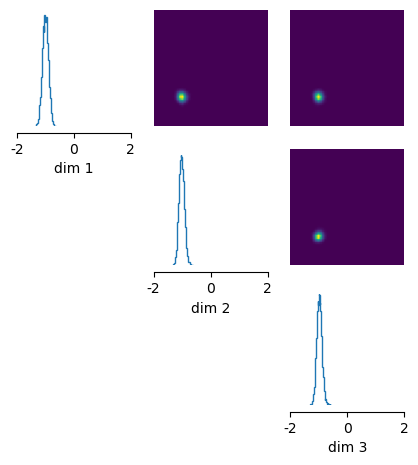

In [22]:
posterior_samples = posterior.sample((10000,), x=x_o)

# Plot posterior samples.
_ = analysis.pairplot(
    posterior_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5)
)